## Recommendation System :
### Both Content Based and Colaborative
* Link: https://www.youtube.com/watch?v=9-HKxxgbsJ8

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys

In [2]:
movies=pd.read_csv('movie.csv')

In [3]:
ratings=pd.read_csv('rating.csv')

In [4]:
tags=pd.read_csv('tag.csv')

In [5]:
movies.shape

(27278, 3)

In [6]:
len(movies.movieId.unique()) #movieId of movie is more

27278

In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## list the movie title that survive in the filtering


In [8]:
len(ratings.movieId.unique()) #movieId of rartings is less

18807

In [13]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [14]:
movies['genres']=movies['genres'].str.replace('|',' ')

In [15]:
ratings_f=ratings.groupby('userId').filter(lambda x: len(x)>=55)

In [16]:
#And we have reduced 43% of the users
len(ratings_f.userId.unique())/len(ratings.userId.unique())*100

58.17908558772346

In [17]:
#no worries: We have kept 100% of the movie titles 
len(ratings_f.movieId.unique())/len(movies.movieId.unique())*100

68.65972578634796

In [18]:
movie_list_rating=ratings_f.movieId.unique().tolist()

### filter the movies Data Frame

In [19]:
movies=movies[movies.movieId.isin(movie_list_rating)]

In [20]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [21]:
#map movie to id
Mapping_file=dict(zip(movies.title.tolist(),movies.movieId.tolist()))

In [22]:
tags.drop(['timestamp'],axis=1,inplace=True)
ratings_f.drop(['timestamp'],axis=1,inplace=True)

## Make Content Based Recommendation
* Content based recomedation is done on text data
* text column is present in 'movies' data set (as genres) and in 'tags' data set (as tags)
* So we combine movie and tags dtaset together

In [23]:
mixed=pd.merge(movies,tags,on='movieId',how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature


## Creating meta data
* It involves removing null values from text data
* It includes combining all the required text together(Concatenation)
* Here we see that there are diffrent tags for same movie
    * so, we combine all tags of same movie together
    * Store this combined tags in a new colum called 'metadata'
* this new column will be used for content based filtering

In [24]:
mixed.fillna("",inplace=True)
mixed= pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % ' '.join(x)))

In [25]:
Final=pd.merge(movies,mixed,on='movieId',how='left')
Final.head(3)

,movieId,title,genres,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...


### creating a 'metadata' column & putting value of concatenating tag and genres

In [26]:
Final['metadata']=Final[['tag','genres']].apply(lambda x: ' '.join(x),axis=1)

In [27]:
Final.head(3)

,movieId,title,genres,tag,metadata
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...,Watched computer animation Disney animated fea...
1,2,Jumanji (1995),Adventure Children Fantasy,time travel adapted from:book board game child...,time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),Comedy Romance,old people that is actually funny sequel fever...,old people that is actually funny sequel fever...


In [28]:
Final[['movieId','genres','metadata']].head(3)

,movieId,genres,metadata
0,1,Adventure Animation Children Comedy Fantasy,Watched computer animation Disney animated fea...
1,2,Adventure Children Fantasy,time travel adapted from:book board game child...
2,3,Comedy Romance,old people that is actually funny sequel fever...


In [29]:
Final.shape

(18729, 5)

## Creating a content Latent Matrix from movie Data
* Latent means reducing dimensionality of the matrix
* Here,we will make a matrix of vectorized words
    * vecorized means every word will be denoted numerically
    * Rows of the matix will bw number of sentences
    * Columns will denote the total number of words
        * For jth column in ith row will tell whether jth word is present in ith sentence or not.
    * This matrix is created by td-Idf vectorizer
        * Stop words like 'for','and' etc will be removed and only important words will me transfromed into matrix

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(stop_words='english')
tfidf_matrix=tfidf.fit_transform(Final['metadata'])
tfidf_df=pd.DataFrame(tfidf_matrix.toarray(),index=Final.index.tolist())
print(tfidf_df.shape)


(18729, 22526)


In [31]:
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=200)
latent_matrix=svd.fit_transform(tfidf_df)

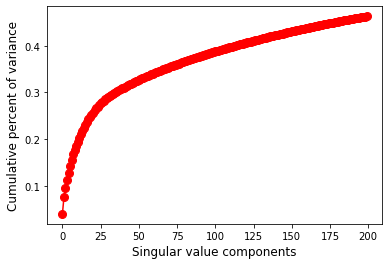

In [33]:
explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16,color='red')
plt.xlabel('Singular value components',fontsize=12)
plt.ylabel('Cumulative percent of variance',fontsize=12)
plt.show()
#the below graph shows that for 200 features more than 45% of data
#if we use more than 200 features , time consumed will be more than the data percent increase

In [34]:
n=200
latent_matrix_1_df=pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [35]:
latent_matrix.shape

(18729, 200)

## For Collaborative(Rating/Numerical) Recommendationj

In [36]:
ratings_f.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [37]:
ratings_f1=pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right" )

In [38]:
ratings_f2=ratings_f1.pivot(index='movieId', columns='userId',values='rating').fillna(0)

In [39]:
ratings_f2.head(3)

userId,1,2,3,5,7,8,11,13,14,16,...,25272,25273,25275,25276,25277,25278,25279,25280,25281,25283
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,4.5,4.0,4.5,3.0,...,0.0,4.0,5.0,0.0,4.0,0.0,0.0,4.5,0.0,0.0
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
ratings_f2.shape

(18729, 14710)

In [41]:
len(ratings_f.movieId.unique())

18729

In [42]:
#Again reducing dimensionality by SVD
from sklearn.decomposition import TruncatedSVD
svd=TruncatedSVD(n_components=200)
latent_matrix_2=svd.fit_transform(ratings_f2)
latent_matrix_2_df=pd.DataFrame(latent_matrix_2, index=Final.title.tolist())

In [43]:
latent_matrix_2_df.shape

(18729, 200)

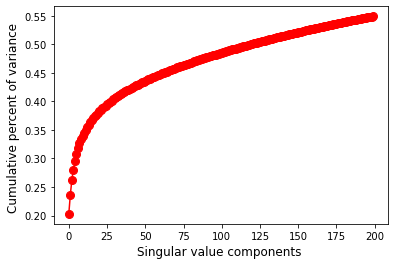

In [44]:
# plot variance explained to see what  latent dimensions to use
explained=svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-',ms=16, color='red')
plt.xlabel('Singular value components ',fontsize=12)
plt.ylabel('Cumulative percent of variance ',fontsize=12)
plt.show()

In [45]:
latent_matrix_1_df.head(3) # content matrix for content based recommendation

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.033641,0.055091,0.024118,0.007937,0.006395,0.030778,-0.034537,0.151520,0.000212,-0.030800,...,0.074859,0.147435,0.038737,-0.001587,-0.016939,-0.001618,0.015962,0.022508,0.013025,0.061345
Jumanji (1995),0.013935,0.012182,0.032863,0.006377,0.016716,0.005254,-0.018555,0.086814,0.004984,-0.011057,...,-0.035777,-0.019805,-0.007536,-0.020154,-0.002577,0.038835,0.021062,-0.030442,0.069842,0.006601
Grumpier Old Men (1995),0.046251,0.072396,-0.002702,0.000791,0.030814,-0.000537,-0.012825,-0.003033,-0.000994,-0.000368,...,0.027984,-0.003873,0.013000,-0.005150,0.024388,-0.024881,0.005216,-0.006492,0.002458,0.016046


In [46]:
latent_matrix_2_df.head(3) # Matrix based on reviews i.e. for collabarative Recommendation

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),241.899977,-3.270660,61.395410,29.731371,16.243795,68.107986,-23.446251,27.099534,-25.546355,6.314342,...,-10.199605,3.904789,-3.260474,-4.944233,-7.634080,-13.271314,0.620050,3.129984,4.133285,-6.789327
Jumanji (1995),110.542578,-2.567716,68.734212,-19.645228,-19.657733,9.245835,-27.153621,20.841513,7.215168,-9.625650,...,7.239717,5.144504,5.107902,3.109195,-3.468422,-3.330702,1.466258,5.420957,1.237146,-0.755578
Grumpier Old Men (1995),45.323679,-21.365718,30.318441,-18.882042,-15.485788,0.634993,-3.043136,0.269722,-10.751159,-11.663624,...,-1.345164,0.745544,-1.536549,0.642533,3.101301,-0.753346,-5.132117,0.140885,-3.945981,-0.454570


## 1) Geting row for similar matrix  from both content's matric & Collaborative's matrix 
## 2) Calculate Similarity Score for both matrices
## 3) Calculate hybrid score from avg of above two scores
## 4) Form a database of similar database
## 5) Sort the similar database and get required recommendation


In [47]:
from sklearn.metrics.pairwise import cosine_similarity
#movie that user likes: Toy Story (1995)
a_1=np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1,-1 ) #this gives similar movies matrix from content based matrix
a_2=np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1,-1)  #gives similar movies row of toy story from user rating

#calculate cosine Similarity of this movie with others in the list
score_1=cosine_similarity(latent_matrix_1_df,a_1).reshape(-1)
score_2=cosine_similarity(latent_matrix_2_df,a_2).reshape(-1)

#an average measure of contentent & colaborative
hybrid= ((score_1+score_2)/2.0)

#form a data frame of similar movies
dictDf={'content':score_1, 'collaborative':score_2, 'hybrid': hybrid}
similar=pd.DataFrame(dictDf, index=latent_matrix_1_df.index)

#sort it on the basis of either: content, collaborative or hybrid
#here: hybrid
similar.sort_values('hybrid', ascending=False, inplace=True)

similar[1:].head(11)


,content,collaborative,hybrid
Toy Story 2 (1999),0.963758,0.743063,0.853411
"Bug's Life, A (1998)",0.910795,0.660196,0.785496
"Monsters, Inc. (2001)",0.891119,0.616348,0.753734
Finding Nemo (2003),0.874132,0.594034,0.734083
"Incredibles, The (2004)",0.797729,0.570459,0.684094
Ice Age (2002),0.877786,0.472669,0.675228
Ratatouille (2007),0.898410,0.417340,0.657875
Antz (1998),0.744086,0.563769,0.653928
Toy Story 3 (2010),0.864155,0.416619,0.640387
Shrek (2001),0.621053,0.631302,0.626177
